In [1]:
from typing import TypedDict , Annotated , Optional
from langgraph.graph import add_messages, StateGraph , END ,START
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import os

/Users/dhanush/Desktop/Perplexity/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)




In [3]:
search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]

/var/folders/18/d46yntc5631fczd0m6bq_14h0000gn/T/ipykernel_17536/3494125344.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=4)


In [4]:
memory = MemorySaver()

llm_with_tools = model.bind_tools(tools)

In [5]:
from langchain_core.messages import HumanMessage , AIMessage ,ToolMessage

class State(TypedDict):
    messages:Annotated[list,add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return "__end__"
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges(
    "model", 
    tools_router,
    path_map={"tool_node": "tool_node", "__end__": "__end__"}
)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

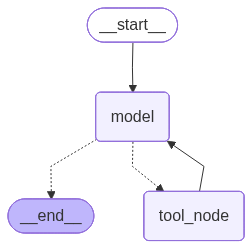

In [6]:
from IPython.display import Image ,display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [7]:
config = {"configurable":{
    "thread_id": "1",
}}

response = await graph.ainvoke({
    "messages" : [HumanMessage(content = "who are the competitors in fibreglass rebar market in india")]
},config = config)

In [8]:
print(response)

{'messages': [HumanMessage(content='who are the competitors in fibreglass rebar market in india', additional_kwargs={}, response_metadata={}, id='faf4911e-df4a-4b2b-930c-36babd7838da'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WZxVOmzJ1VviCNgpp2zd9hpE', 'function': {'arguments': '{"query":"fibreglass rebar market competitors in India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 92, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-COC6EpnGBbyQwbToVeQgCBOY49AZJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c964e087-78b8-4e2d-b57e-ae9e4745

In [9]:

config = {"configurable":{"thread_id":1}}

async for event in graph.astream_events(
    {"messages" : [HumanMessage(content = "who are the competitors in fibreglass rebar market in india")]},config = config
):
    print(event)
        


{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='who are the competitors in fibreglass rebar market in india', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'f54053d4-9c3f-4187-b9f5-8babdafaeff1', 'metadata': {'thread_id': 1}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='who are the competitors in fibreglass rebar market in india', additional_kwargs={}, response_metadata={}, id='faf4911e-df4a-4b2b-930c-36babd7838da'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WZxVOmzJ1VviCNgpp2zd9hpE', 'function': {'arguments': '{"query":"fibreglass rebar market competitors in India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 92, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 

In [ ]:
# Clean solution: Extract only the final AI response
config = {"configurable": {"thread_id": str(uuid4())}}

async for event in graph.astream_events({
    "messages" : [HumanMessage(content = "what is the market demand for fibreglass rebar market in india")]
}, config = config) :
    
    if event["event"] == "on_chain_stream":
        chunk_data = event["data"]["chunk"]
        
        # Check if this chunk contains AI messages with actual content
        if "messages" in chunk_data:
            for message in chunk_data["messages"]:
                # Look for AIMessage with non-empty content
                if (hasattr(message, 'content') and 
                    message.content and 
                    hasattr(message, '__class__') and
                    message.__class__.__name__ == "AIMessage"):
                    print(message.content, end="", flush=True)


The market demand for fiberglass rebar (FRP rebar) in India is experiencing significant growth, driven by various government initiatives and infrastructure projects. Here are some key insights:

1. **Government Initiatives**: The Indian government is investing heavily in infrastructure, including the establishment of multi-modal logistics parks and the expansion of the road network, which is projected to reach 200,000 kilometers by 2025. This is expected to boost the demand for FRP rebar significantly.

2. **Market Growth Projections**: The FRP rebar market in India is projected to see substantial expansion, with forecasts indicating a compound annual growth rate (CAGR) of around 6.6% from 2024 to 2030. The market is expected to reach a revenue of approximately USD 29.4 million by 2030.

3. **Applications**: The demand for fiberglass rebar is particularly strong in applications such as metro tunneling, highways, bridges, and other infrastructure projects, where lightweight and corrosio